In [1]:
%load_ext autoreload
%autoreload 2

import os, gc
import numpy as np
import random
from tqdm import tqdm
import torch
from models.cnn_nlp import CNN_NLP
from pympler import asizeof
%matplotlib inline


import json


import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler

from sqlalchemy.orm import Session
from sqlalchemy import create_engine, select, MetaData, Table, and_

with open ('../settings.json') as f:
    settings = json.load(f)

DATA_DIR = os.path.join(settings['data_path'], 'classifier')
os.makedirs(DATA_DIR, exist_ok=True)
CHECKPOINT_DIR = os.path.join(DATA_DIR, "model_data")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_PREFIX = os.path.join(CHECKPOINT_DIR, "cnn_exmple")

db_uri = settings['sqlalchemy_database_uri']

RANDOM_SEED = 4321
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCABULARY_SIZE = 52000
LEARNING_RATE = 0.05
EMBEDDING_DIM = 128
DROPOUT = 0.5
BATCH_SIZE = 32
NUM_EPOCHS = 15
NUM_CLASSES = 4
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# Enable synchronous CUDA execution for better error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Enable device-side assertions in CUDA kernels
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Confirm the variables are set
print("CUDA_LAUNCH_BLOCKING =", os.getenv('CUDA_LAUNCH_BLOCKING'))
print("TORCH_USE_CUDA_DSA =", os.getenv('TORCH_USE_CUDA_DSA'))


CUDA_LAUNCH_BLOCKING = 1
TORCH_USE_CUDA_DSA = 1


In [3]:
import os, json
with open ('../settings.json') as f:
    settings = json.load(f)

DATA_DIR = os.path.join(settings['data_path'], 'classifier')
os.makedirs(DATA_DIR, exist_ok=True)
REPORT_DIR = os.path.join(DATA_DIR, "report_data")
os.makedirs(REPORT_DIR, exist_ok=True)

In [4]:
from datasets import load_dataset


file_paths = [  os.path.join(REPORT_DIR, 'json_0.json'),
                os.path.join(REPORT_DIR, 'json_19.json')]

dataset = load_dataset('json', data_files=file_paths)['train']
print(dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})


In [5]:
# First, split into 80% train and 20% (validation + test), with shuffling
train_test_split = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']

# Then, split the 20% temp_dataset into 10% validation and 10% test, with shuffling
validation_test_split = temp_dataset.train_test_split(test_size=0.5, seed=42, shuffle=True)
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']

# Check the size and order of samples in each split
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(validation_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

Train dataset: 1600 samples
Validation dataset: 200 samples
Test dataset: 200 samples


In [6]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=EMBEDDING_DIM,
                    filter_sizes=[3, 4, 5],
                    num_filters=[10, 10, 10],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=dropout)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(DEVICE)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [7]:
tokenizer_path = os.path.join(DATA_DIR, 'model_data', 'mal-reformer')
print(f"Tokenizer path: {tokenizer_path}")

import torch
from transformers import AutoTokenizer, ReformerForSequenceClassification

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
tokenizer.pad_token = "[PAD]"
tokenizer.cls_token = "[CLS]"
tokenizer.sep_token = "[SEP]"

Tokenizer path: /media/mike/data/gimc/classifier/model_data/mal-reformer


In [8]:
# Define a tokenization function
max_sequence_length = 20480 * 2
def tokenize_function(example):
    return tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=max_sequence_length
    )

In [9]:
# Tokenize each split
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

In [10]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,SequentialSampler)

def data_loader(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE):
    train_inputs, val_inputs, test_inputs = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    
    for i in tqdm(range(len(train_dataset)), desc="Tokenizing train dataset"):
        train_inputs.append(train_dataset[i]['input_ids'])
        train_labels.append(train_dataset[i]['label'])
    for i in tqdm(range(len(val_dataset)), desc="Tokenizing validation dataset"):
        val_inputs.append(val_dataset[i]['input_ids'])
        val_labels.append(val_dataset[i]['label'])
    for i in tqdm(range(len(test_dataset)), desc="Tokenizing test dataset"):
        test_inputs.append(test_dataset[i]['input_ids'])
        test_labels.append(test_dataset[i]['label'])

    # Convert data type to torch.Tensor
    train_inputs = torch.tensor(train_inputs)
    val_inputs = torch.tensor(val_inputs)
    test_inputs = torch.tensor(test_inputs)
    train_labels = torch.tensor(train_labels)
    val_labels = torch.tensor(val_labels)
    test_labels = torch.tensor(test_labels)
                                   
    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    # create DataLoader for test data
    test_data = TensorDataset(test_inputs, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    return train_dataloader, val_dataloader, test_dataloader

In [11]:
train_dataloader, val_dataloader, test_dataloader = data_loader(tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset)

Tokenizing test dataset: 100%|██████████| 200/200 [00:09<00:00, 21.73it/s]


/home/mike/projects/GIMC/env/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 001/015 | Train: 82.31% | Validation: 83.50% | Elapsed: 0.12 min
Epoch: 002/015 | Train: 95.19% | Validation: 94.50% | Elapsed: 0.24 min
Epoch: 003/015 | Train: 94.44% | Validation: 94.00% | Elapsed: 0.36 min
Epoch: 004/015 | Train: 94.62% | Validation: 94.00% | Elapsed: 0.47 min
Epoch: 005/015 | Train: 95.25% | Validation: 94.00% | Elapsed: 0.59 min
Epoch: 006/015 | Train: 94.94% | Validation: 94.00% | Elapsed: 0.70 min
Epoch: 007/015 | Train: 95.25% | Validation: 94.00% | Elapsed: 0.82 min
Epoch: 008/015 | Train: 95.56% | Validation: 94.00% | Elapsed: 0.94 min
Epoch: 009/015 | Train: 95.56% | Validation: 94.50% | Elapsed: 1.06 min
Epoch: 010/015 | Train: 95.62% | Validation: 94.50% | Elapsed: 1.17 min
Epoch: 011/015 | Train: 97.00% | Validation: 98.00% | Elapsed: 1.28 min
Epoch: 012/015 | Train: 97.19% | Validation: 98.00% | Elapsed: 1.40 min
Epoch: 013/015 | Train: 97.31% | Validation: 98.00% | Elapsed: 1.51 min
Epoch: 014/015 | Train: 97.38% | Validation: 98.00% | Elapsed: 1

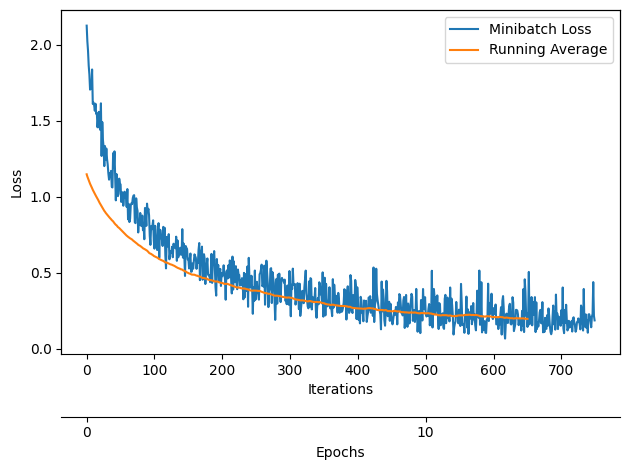

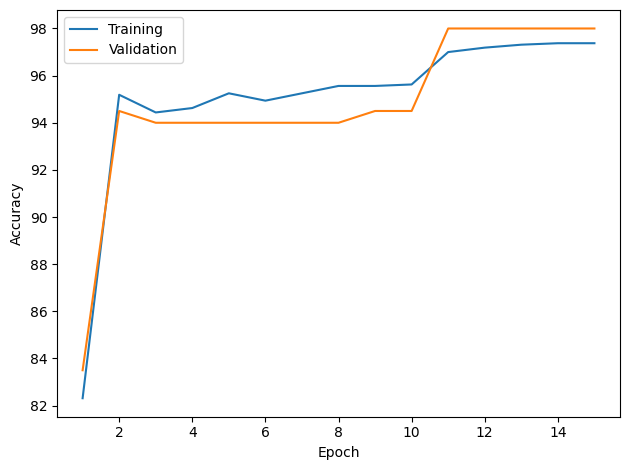

In [12]:
from utils.train import train_model
from utils.plot import plot_accuracy, plot_training_loss

model, optimizer = initilize_model(vocab_size=VOCABULARY_SIZE,
                                   embed_dim=EMBEDDING_DIM,
                                   dropout=DROPOUT,
                                   learning_rate=LEARNING_RATE,
                                   num_classes=NUM_CLASSES)

model = model.to(DEVICE)
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_dataloader,
    valid_loader=val_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    checkpoint_prefix=CHECKPOINT_PREFIX,
    device=DEVICE,
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataloader),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)